In [1]:
import sys

sys.path.append('../../MembraneQuant')
from membranequant import *
import seaborn as sns
import scipy.odr as odr
from scipy.optimize import curve_fit
import sympy as sp
import scipy.stats as st

%matplotlib notebook

### Load data

In [2]:
df = pd.read_csv('res1_df.csv')
# df

In [3]:
x_norm = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Cyt.to_numpy())
y_norm = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Mem_tot.to_numpy())

print(x_norm)
print(y_norm)
print(y_norm / x_norm)

3268.514078922549
11036.742624360773
3.376685049494719


In [4]:
x_wt = df[df.Line == 'nwg201'].Cyt.to_numpy() / x_norm
y_wt = df[df.Line == 'nwg201'].Mem_tot.to_numpy() / y_norm
x_wt_full = df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Cyt.to_numpy() / x_norm
y_wt_full = df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Mem_tot.to_numpy() / y_norm

x_l109r = df[df.Line == 'nwg369'].Cyt.to_numpy() / x_norm
y_l109r = df[df.Line == 'nwg369'].Mem_tot.to_numpy() / y_norm
x_l109r_full = df[(df.Line == 'nwg369') & (df.Condition == 'wt')].Cyt.to_numpy() / x_norm
y_l109r_full = df[(df.Line == 'nwg369') & (df.Condition == 'wt')].Mem_tot.to_numpy() / y_norm

x_pol = df[df.Line == 'nwg325'].Cyt.to_numpy() / x_norm
y_pol = df[df.Line == 'nwg325'].Mem_post.to_numpy() / y_norm
x_pol_full = df[(df.Line == 'nwg325') & (df.Condition.isin(['wt', 'tom4,15,60']))].Cyt.to_numpy() / x_norm
y_pol_full = df[(df.Line == 'nwg325') & (df.Condition.isin(['wt', 'tom4,15,60']))].Mem_post.to_numpy() / y_norm

In [5]:
# x_wt = df[df.Line == 'nwg201'].Cyt.to_numpy() / x_norm
# y_wt = df[df.Line == 'nwg201'].Mem_post.to_numpy() / y_norm
# x_wt_full = df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Cyt.to_numpy() / x_norm
# y_wt_full = df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Mem_post.to_numpy() / y_norm

# x_l109r = df[df.Line == 'nwg369'].Cyt.to_numpy() / x_norm
# y_l109r = df[df.Line == 'nwg369'].Mem_post.to_numpy() / y_norm
# x_l109r_full = df[(df.Line == 'nwg369') & (df.Condition == 'wt')].Cyt.to_numpy() / x_norm
# y_l109r_full = df[(df.Line == 'nwg369') & (df.Condition == 'wt')].Mem_post.to_numpy() / y_norm

# x_pol = df[df.Line == 'nwg325'].Cyt.to_numpy() / x_norm
# y_pol = df[df.Line == 'nwg325'].Mem_post.to_numpy() / y_norm
# x_pol_full = df[(df.Line == 'nwg325') & (df.Condition.isin(['wt', 'tom4,15,60']))].Cyt.to_numpy() / x_norm
# y_pol_full = df[(df.Line == 'nwg325') & (df.Condition.isin(['wt', 'tom4,15,60']))].Mem_post.to_numpy() / y_norm

### Conversion factors

Model uses real units, but must be converted to normalised units (cyt and mem approx on range 0-1) for optimisation as optimiser uses orthogonal distance. Hence the division above.

To convert back, multiply by appropriate factors. Actually, just need to multiply mem by y_norm / x_norm = 3.5

Also need to put cytoplasm and membrane in equivalent units. 1 membrane unit (pre) division = 3.5 cytoplasmic units (i.e. arbitraty units per um3 vs same arbitrary units per um2). This was calculated using the optogenetics method, but needs to be updated.

Then need to convert membrane units to um3. Multiply by 1 / effective_thickness_of_cortex_in_um. Thickness is approx 0.01um, but this is an estimate. Probably need to play around with this parameter.

Also need to put in absolute units. Really we have no way of knowing what these should be...


So to summarise:

Mem: * 3.5 * (y_norm / x_norm) * (1 / a) * b

Cyt: * b

In [6]:
a = 0.01
b = 1e-5

xc = b
xm = 3.5 * (y_norm / x_norm) * (1 / a) * b

### Analysis functions

In [7]:
def fitting(model, cyts, mems):
    # Ols fit
    popt, pcov = curve_fit(model, cyts, mems)
    params_0 = popt

    # Odr fit
    def perform_odr(x, y):
        quadr = odr.Model(lambda B, x: model(x, *B))
        mydata = odr.Data(x, y)
        myodr = odr.ODR(mydata, quadr, beta0=params_0)
        output = myodr.run()
        return output

    regression = perform_odr(cyts, mems)
    params = regression.beta
            
    return params

def bootstrap_fitting(model, cyts, mems, n):
    params = []
    for i in range(n):  
        inds = np.random.choice(range(len(cyts)), len(cyts))
        try:
            params.append(fitting(model, cyts[inds], mems[inds]))
        except:
            pass
        
    return params

def confidence_interval(model, cyts, mems, params, interval=95, n_x=100): 
    x = np.linspace(0, max(cyts), n_x)
    all_fits = np.zeros([len(x), len(params)])
    for i, _x in enumerate(x):
        for j, p in enumerate(params):
            all_fits[i, j] = model(_x, *p)
    
    all_fits_lower = np.percentile(all_fits, (100 - interval) / 2, axis=1)
    all_fits_upper = np.percentile(all_fits, 50 + (interval / 2), axis=1)
    params_lower = np.percentile(np.array(params), (100 - interval) / 2, axis=0)
    params_upper = np.percentile(np.array(params), 50 + (interval / 2), axis=0)
    return [x, all_fits_lower, all_fits_upper], [params_lower, params_upper]

### Solve equations - effective 2 state model simplified

In [8]:
def model(cyt, ka, km):
    c = cyt * xc
    m = c * km * (c * ka * km * (2 * c * ka + np.sqrt(4 * c * ka + 1) + 1) + np.sqrt(
        4 * c ** 3 * ka ** 3 + 6 * c ** 2 * ka ** 2 * np.sqrt(
            4 * c * ka + 1) + 18 * c ** 2 * ka ** 2 + 8 * c * ka * np.sqrt(
            4 * c * ka + 1) + 12 * c * ka + 2 * np.sqrt(4 * c * ka + 1) + 2)) / (
                2 * c ** 2 * ka ** 2 + 2 * c * ka * np.sqrt(4 * c * ka + 1) + 4 * c * ka + np.sqrt(4 * c * ka + 1) + 1)
    return m / xm

In [19]:
# def model_no_cyt(cyt, km):
#     c = cyt * xc
#     m = c * km
#     return m / xm

### Fitting with L109R dimer energy = 0

Gives membrane energy (and confidence interval for this)

Just fitting wild type (non-rundown) data

In [27]:
model_no_dim = lambda cyt, km: model(cyt, 0, km)

km = fitting(model_no_dim, x_l109r_full, y_l109r_full)
km_bootstrap_ = bootstrap_fitting(model_no_dim, x_l109r_full, y_l109r_full, 1000)
print(km, np.log(km))

[645.90591615] [6.47065385]


<IPython.core.display.Javascript object>


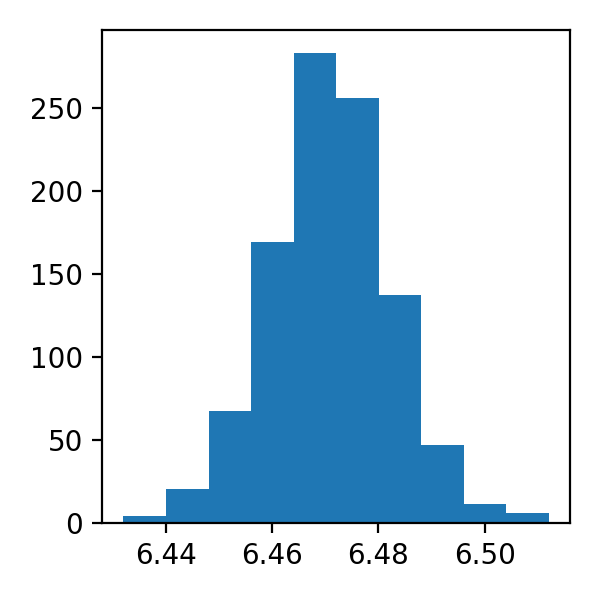

In [28]:
fig, ax = plt.subplots()
ax.hist(np.log(np.array(km_bootstrap)), bins=10);
fig.set_size_inches(3, 3)
fig.tight_layout()

### Fitting dimer energy for wild type

In [11]:
model_restricted_km = lambda cyt, ka: model(cyt, ka, km)

ka = fitting(model_restricted_km, x_wt_full, y_wt_full)
ka_bootstrap = bootstrap_fitting(model_restricted_km, x_wt_full, y_wt_full, 1000)
print(ka, np.log(ka))

[125.9615883] [4.83597701]


<IPython.core.display.Javascript object>


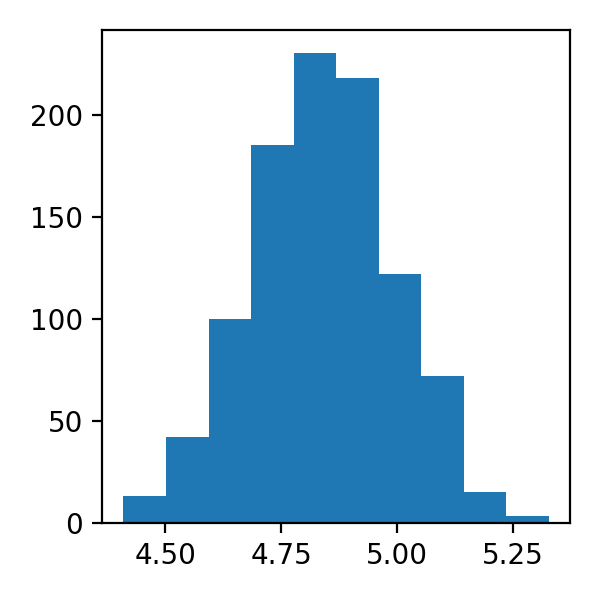

In [12]:
fig, ax = plt.subplots()
ax.hist(np.log(np.array(ka_bootstrap)), bins=10);
fig.set_size_inches(3, 3)
fig.tight_layout()

### Fitting dimer energy to wild type (with km uncertainty)

In [13]:
def bootstrap_fitting_ka(cyts, mems, n):
    params = []
    _km = np.random.choice(np.array(km_bootstrap).flatten(), n)
    for i in range(n):  
        inds = np.random.choice(range(len(cyts)), len(cyts))
        _model = lambda cyt, ka: model(cyt, ka, _km[i])
        params.append(fitting(_model, cyts[inds], mems[inds])) 
    return _km, np.array(params).flatten()

(1000,)
(1000,)
(1000, 2)


<IPython.core.display.Javascript object>


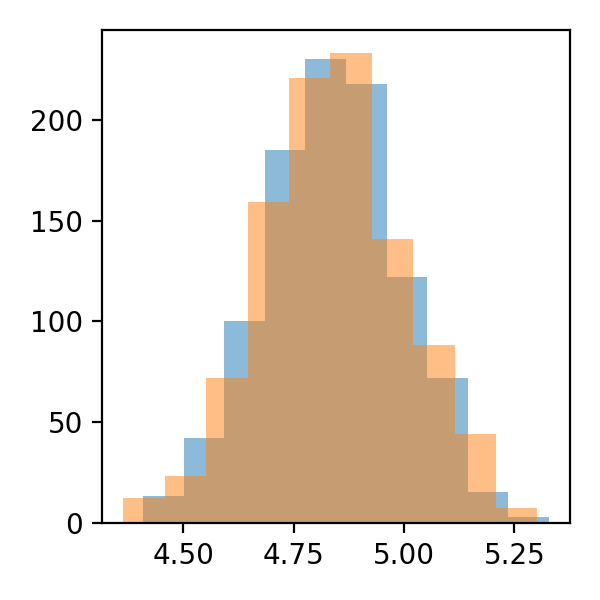

In [14]:
km_bootstrap2, ka_bootstrap2 = bootstrap_fitting_ka(x_wt_full, y_wt_full, 1000)

print(km_bootstrap2.shape)
print(ka_bootstrap2.shape)

print(np.array([km_bootstrap2, ka_bootstrap2]).T.shape)

fig, ax = plt.subplots()
ax.hist(np.log(ka_bootstrap), bins=10, alpha=0.5);
ax.hist(np.log(ka_bootstrap2), bins=10, alpha=0.5);
fig.set_size_inches(3, 3)
fig.tight_layout()

<IPython.core.display.Javascript object>


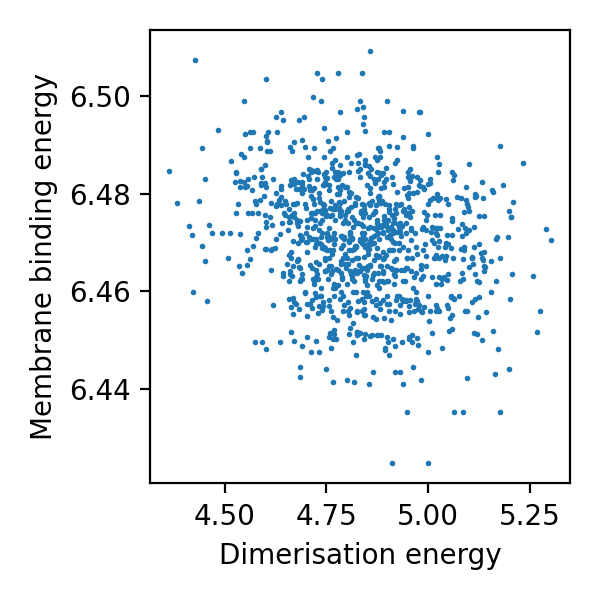

In [15]:
fig, ax = plt.subplots()
ax.scatter(np.log(ka_bootstrap2), np.log(km_bootstrap2), s=1)
# ax.set_xlim(0, 10)
# ax.set_ylim(0, 10)
ax.set_xlabel('Dimerisation energy')
ax.set_ylabel('Membrane binding energy')
fig.set_size_inches(3,3)
fig.tight_layout()

### Fitting dimer energy for wt polarised

In [16]:
# ka_pol = fitting(model_restricted_km, x_pol_full, y_pol_full)
# ka_pol_bootstrap = bootstrap_fitting(model_restricted_km, x_pol_full, y_pol_full, 1000)
# print(ka_pol, np.log(ka_pol))

In [17]:
# fig, ax = plt.subplots()
# ax.hist(np.log(np.array(ka_pol_bootstrap)), bins=10);
# fig.set_size_inches(3, 3)
# fig.tight_layout()

### Rundown predictions

<IPython.core.display.Javascript object>


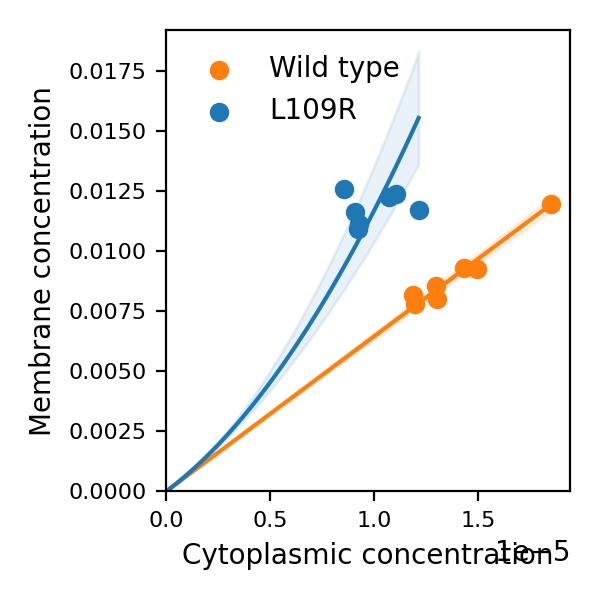

In [33]:
fig, ax = plt.subplots()

# L109R
# ax.scatter(xc * x_l109r, xm * y_l109r, edgecolor='tab:orange', facecolor='none')
ax.scatter(xc * x_l109r_full, xm * y_l109r_full, c='tab:orange', label='Wild type')
ax.plot(xc * np.linspace(0, max(x_l109r), 100), xm * model_no_dim(np.linspace(0, max(x_l109r), 100), km), 
        c='tab:orange')
ci_l109r, _ = confidence_interval(model_no_dim, x_l109r, y_l109r, km_bootstrap, interval=95)
ax.fill_between(xc * ci_l109r[0], xm * ci_l109r[1], xm * ci_l109r[2], color='tab:orange', alpha=0.1)

# Wild type
# ax.scatter(xc * x_wt, xm * y_wt, edgecolor='tab:blue', facecolor='none')
ax.scatter(xc * x_wt_full, xm * y_wt_full, c='tab:blue', label='L109R')
ax.plot(xc * np.linspace(0, max(x_wt), 100), xm * model_restricted_km(np.linspace(0, max(x_wt), 100), ka), 
        c='tab:blue')
ci_wt, _ = confidence_interval(model, x_wt, y_wt, np.array([ka_bootstrap2, km_bootstrap2]).T.tolist(), interval=95)
ax.fill_between(xc * ci_wt[0], xm * ci_wt[1], xm * ci_wt[2], color='tab:blue', alpha=0.1)

# Wild type, pol
# ax.scatter(x_pol, y_pol, edgecolor='tab:green', facecolor='none')
# ax.scatter(x_pol_full, y_pol_full, c='tab:green')
# ax.plot(np.linspace(0, max(x_pol), 100), model_restricted_km(np.linspace(0, max(x_pol), 100), ka_pol))

# Finalise fig
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend(frameon=False, loc=2)
ax.set_xlabel('Cytoplasmic concentration')
ax.set_ylabel('Membrane concentration')
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('Model_fitting_figs/method2.png', dpi=600, transparent=True)

### Bar chart - energies

<IPython.core.display.Javascript object>


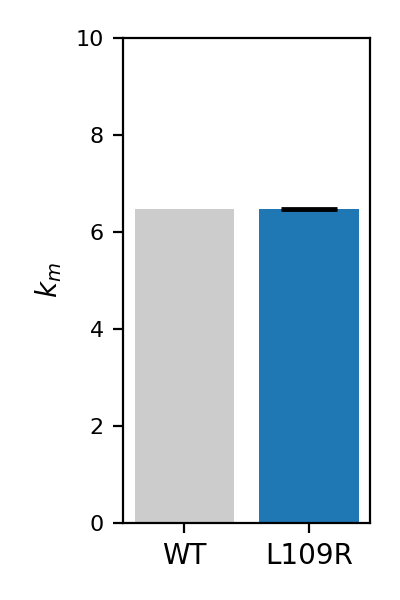

In [58]:
fig, ax = plt.subplots()
ax.bar(0, np.log(km), color='0.8')
ax.bar(1, np.log(km), color='tab:blue', capsize=10, yerr=[np.log(np.percentile(km_bootstrap, 97.5)) - np.log(km),
                                                          - np.log(np.percentile(km_bootstrap, 2.5)) + np.log(km)])
ax.set_xticks([0, 1])
ax.set_xticklabels(['WT', 'L109R'])
ax.set_ylabel(r'$k_m$')
ax.set_ylim(0, 10)
ax.tick_params(axis='y', labelsize=8)
fig.set_size_inches(2,3)
fig.tight_layout()

<IPython.core.display.Javascript object>


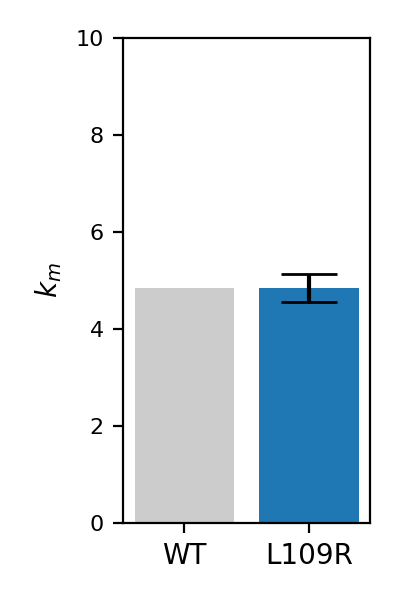

In [60]:
fig, ax = plt.subplots()
ax.bar(0, np.log(ka), color='0.8')
ax.bar(1, np.log(ka), color='tab:blue', capsize=10, yerr=[np.log(np.percentile(ka_bootstrap, 97.5)) - np.log(ka),
                                                          - np.log(np.percentile(ka_bootstrap, 2.5)) + np.log(ka)])
ax.set_xticks([0, 1])
ax.set_xticklabels(['WT', 'L109R'])
ax.set_ylabel(r'$k_m$')
ax.set_ylim(0, 10)
ax.tick_params(axis='y', labelsize=8)
fig.set_size_inches(2,3)
fig.tight_layout()